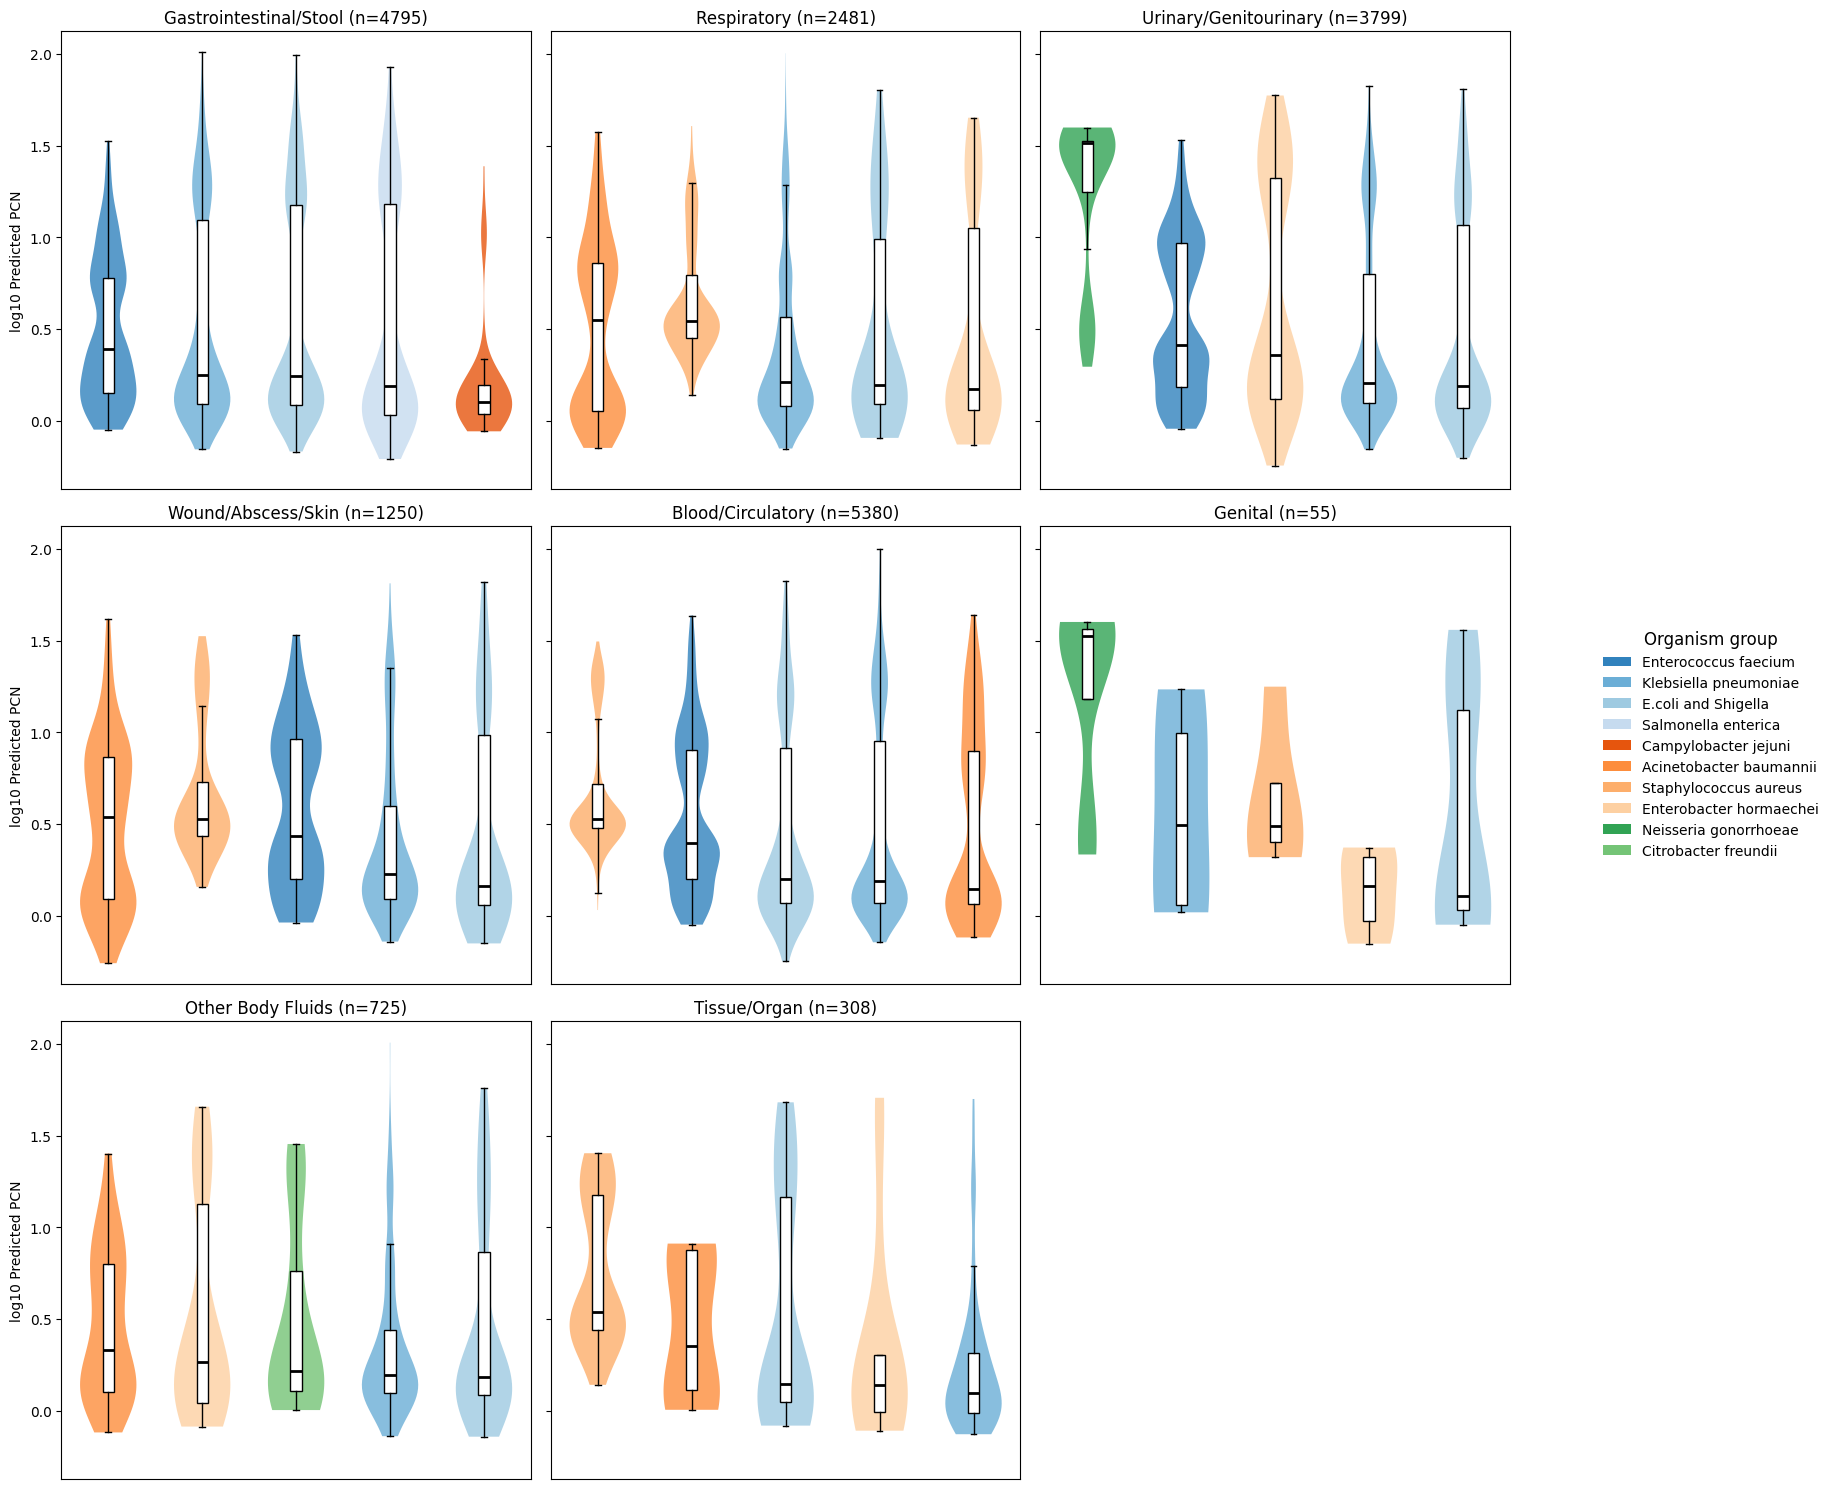

✅ Saved: /mnt/c/Figure4/S2Ca2.pdf


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load data
df = pd.read_csv('Figure_4_data.csv')

COL_SRC   = 'Group'
COL_GROUP = 'Organism group'
COL_PCN   = 'Predicted_PCN_backtransformed'

# Exclude unwanted source and organism group
df = df[df[COL_SRC] != 'Miscellaneous/Unspecified Clinical']
df = df[df[COL_GROUP] != 'Edwardsiella ictaluri']

# === 4) Add log10-transformed PCN ===
df['log10_PCN'] = np.log10(df[COL_PCN])

# === 5) Get all remaining sources ===
all_sources = df[COL_SRC].unique().tolist()

# === 6) For each source, get top 5 organism groups by count and sort by median ===
top5_per_source = {}
all_groups = []

for src in all_sources:
    sub = df[df[COL_SRC] == src]
    top5 = (
        sub[COL_GROUP]
        .value_counts()
        .nlargest(5)
        .index
        .tolist()
    )
    medians = sub.groupby(COL_GROUP)['log10_PCN'].median()
    sorted_top5 = sorted(top5, key=lambda g: medians.get(g, np.nan), reverse=True)
    top5_per_source[src] = sorted_top5
    all_groups.extend(sorted_top5)

# === 7) Remove duplicates from group list ===
all_groups = list(dict.fromkeys(all_groups))

# === 8) Assign consistent colors ===
palette = plt.get_cmap('tab20c').colors
color_map = {grp: palette[i % len(palette)] for i, grp in enumerate(all_groups)}

# === 9) Setup subplot grid (auto layout) ===
n_sources = len(all_sources)
ncols = 3
nrows = int(np.ceil(n_sources / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows), sharey=True)
axes = axes.flatten()

for idx, (ax, src) in enumerate(zip(axes, all_sources)):
    sub  = df[df[COL_SRC] == src]
    top5 = top5_per_source[src]
    pos  = np.arange(len(top5))
    data = [sub[sub[COL_GROUP] == g]['log10_PCN'].values for g in top5]

    # Violin plot
    vp = ax.violinplot(data, positions=pos, widths=0.6, showextrema=False)
    for i, body in enumerate(vp['bodies']):
        grp = top5[i]
        body.set_facecolor(color_map[grp])
        body.set_edgecolor('none')
        body.set_alpha(0.8)

    # Boxplot overlay
    ax.boxplot(
        data, positions=pos, widths=0.12,
        whis=1.5, showfliers=False, patch_artist=True,
        boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
        whiskerprops=dict(color='black', linewidth=1),
        capprops=dict(color='black', linewidth=1),
        medianprops=dict(color='black', linewidth=2),
    )

    # Axis styling
    ax.set_xticks([])
    ax.set_title(f"{src} (n={len(sub)})", fontsize=12, fontweight='normal')
    if idx % ncols == 0:
        ax.set_ylabel('log10 Predicted PCN', fontweight='normal')

# === 10) Remove empty subplots ===
for j in range(len(all_sources), len(axes)):
    fig.delaxes(axes[j])

# === 11) Legend ===
legend_handles = [Patch(facecolor=color_map[g], label=g) for g in all_groups]
fig.legend(
    handles=legend_handles,
    loc='center right',
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    title='Organism group',
    title_fontsize=12,
    labelspacing=0.5
)

# === 12) Final layout ===
plt.tight_layout(rect=[0, 0, 0.85, 1.0])
out_pdf = 'S4_D.pdf'
fig.savefig(out_pdf, dpi=1200, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {out_pdf}")


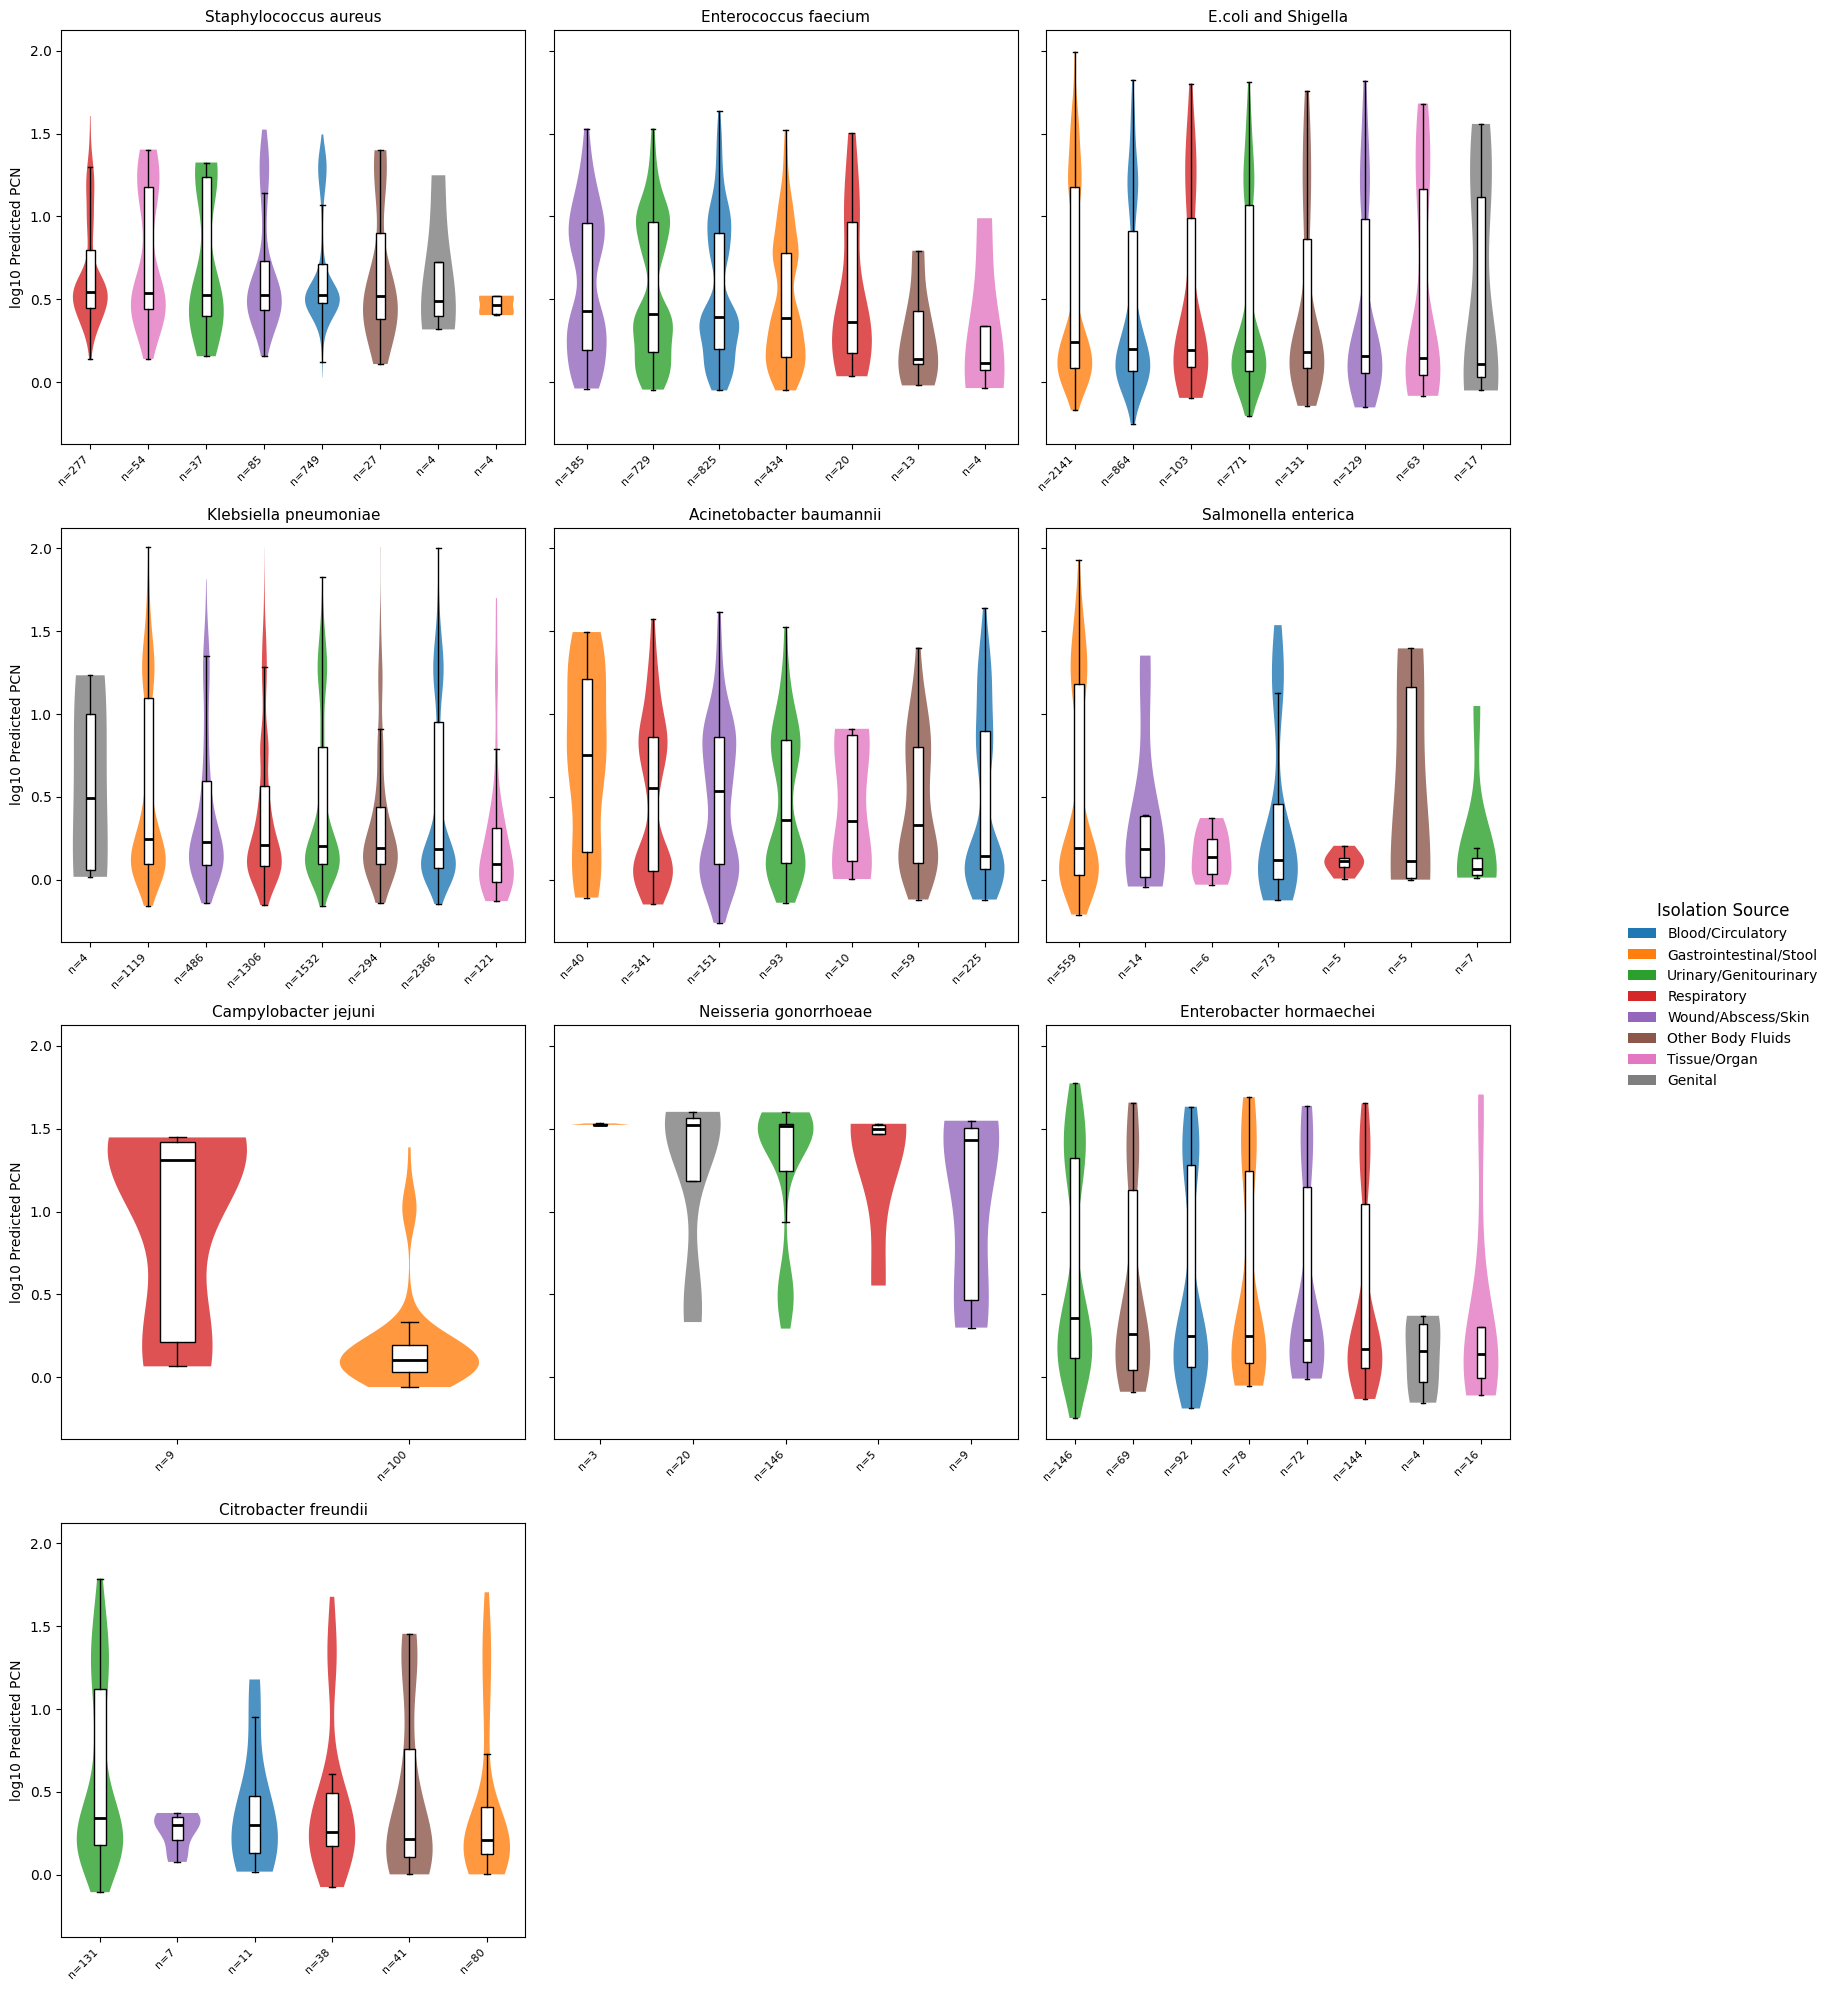

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# === Load Data ===
df = pd.read_csv('Figure_4_data.csv')

# Column Names
COL_SRC = 'Group'
COL_GROUP = 'Organism group'
COL_PCN = 'Predicted_PCN_backtransformed'

# Define Organism Groups and Isolation Sources
target_groups = [
    "Staphylococcus aureus", "Enterococcus faecium", "E.coli and Shigella",
    "Klebsiella pneumoniae", "Acinetobacter baumannii", "Salmonella enterica",
    "Campylobacter jejuni", "Neisseria gonorrhoeae", "Enterobacter hormaechei",
    "Citrobacter freundii"
]

target_sources = [
    "Blood/Circulatory", "Gastrointestinal/Stool", "Urinary/Genitourinary",
    "Respiratory", "Wound/Abscess/Skin", "Other Body Fluids", "Tissue/Organ", "Genital"
]

# === Data Preprocessing ===
df = df[df[COL_GROUP].isin(target_groups)]
df = df[df[COL_SRC].isin(target_sources)]

# Log-transform PCN and handle infinities
df['log10_PCN'] = np.log10(df[COL_PCN])
df = df.replace([np.inf, -np.inf], np.nan)

# Plot layout settings
group_order = target_groups
source_order = target_sources

palette = plt.get_cmap('tab10').colors
color_map = {src: palette[i % len(palette)] for i, src in enumerate(source_order)}

# === Setup Panel Plot ===
n_panels = len(group_order)
ncols = 3
nrows = int(np.ceil(n_panels / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows), sharey=True)
axes = axes.flatten()

# === Violin Plots ===
for idx, group in enumerate(group_order):
    ax = axes[idx]
    sub_df = df[df[COL_GROUP] == group]

    # Prepare and filter source data (exclude n=1)
    source_values = {
        src: sub_df[sub_df[COL_SRC] == src]['log10_PCN'].dropna().values
        for src in source_order
    }
    source_values = {src: vals for src, vals in source_values.items() if len(vals) > 1}  # <-- Exclude n=1

    if not source_values:
        ax.set_visible(False)
        continue

    # Sort sources by descending median
    sorted_sources = sorted(source_values.keys(), key=lambda s: np.median(source_values[s]), reverse=True)
    plot_data = [source_values[src] for src in sorted_sources]
    valid_sources = sorted_sources
    pos = np.arange(len(valid_sources))
    sample_counts = {src: len(source_values[src]) for src in valid_sources}

    # Violin plot
    vp = ax.violinplot(plot_data, positions=pos, widths=0.6, showextrema=False)
    for i, body in enumerate(vp['bodies']):
        body.set_facecolor(color_map[valid_sources[i]])
        body.set_edgecolor('none')
        body.set_alpha(0.8)

    # Boxplot overlay
    ax.boxplot(
        plot_data, positions=pos, widths=0.15, whis=1.5, showfliers=False, patch_artist=True,
        boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
        whiskerprops=dict(color='black', linewidth=1),
        capprops=dict(color='black', linewidth=1),
        medianprops=dict(color='black', linewidth=2),
    )

    ax.set_title(group, fontsize=11)
    ax.set_xticks(pos)
    ax.set_xticklabels([f"n={sample_counts[src]}" for src in valid_sources], rotation=45, ha='right', fontsize=8)

    if idx % ncols == 0:
        ax.set_ylabel('log10 Predicted PCN')

# Hide unused axes
for i in range(len(group_order), len(axes)):
    fig.delaxes(axes[i])

# === Legend ===
legend_handles = [Patch(facecolor=color_map[src], label=src) for src in source_order]
fig.legend(
    handles=legend_handles, loc='center right', bbox_to_anchor=(1.02, 0.5),
    frameon=False, title='Isolation Source', title_fontsize=12, labelspacing=0.5
)

# === Layout and Save ===
plt.tight_layout(rect=[0, 0, 0.85, 1.0])
fig.savefig('S4_E.pdf', dpi=1200, bbox_inches='tight')
plt.show()
